# Оптимальный дизайн эксперимента
В этом задании мы научимся подбирать оптимальный дизайн эксперимента и рассчитаем размер выборки для достижения заданной мощности.

Для того, чтобы поработать с данными, вам нужно будет сначала выгрузить их из базы. Помните, где лежат наши таблицы? Верно, в ClickHouse! Вспоминайте логин-пароль и переходите к следующему степу – начнем с написания запроса для получения нужной выборки.

Задание будет состоять из четырех задач.

Общее количество баллов за задание: 100 баллов.

Сделаем нужную выгрузку.

Подготовьте SQL запрос для клиентов, совершивших оплату в Москве в период с 11 по 16 октября 2022 г. за услугу "premium".

Пояснения для формирования SQL запроса:

1) Используйте таблицу user_transactions, чтобы оставить только тех пользователей, кто воспользовался платными услугами 'premium' в указанный период. Размер выручки от каждого покупателя услуги считается как сумма всех списанных денег (amount) при условии sign = -1 (т.е. деньги были списаны со счета покупателя).

2) Используйте таблицу dp_live_adverts для того, чтобы оставить объявления, размещенные в Москве. Обратите внимание, что одно и то же объявление может быть опубликовано в течение длительного периода (execution_date), а оплата за услугу может быть произведена в выборочные дни (payment_date). Учитывайте дату платежа и номер объявления при join'e таблиц.

3) Из запроса сформируйте датасет, включающий данные по выручке, которую приносит каждый пользователь (нужно взять passport_id !) в Москве за указанное время.

Чтобы убедиться, что вы все сделали правильно, ответьте на следующий вопрос.

In [ ]:
from clickhouse_driver import Client 

# Создаем соединение с ClickHouse 
client = Client(host='clickhouse.lab.karpov.courses', port=9000, user='ваш логин', password='ваш пароль', database='hardda')

# Отправляем запрос 
result = client.execute("SELECT * FROM user_dm_events LIMIT 10")

# Обрабатываем результаты запроса 
for row in result: 
    print(row)
    
def get_data(query):
    """
    Выгружает данные из ClickHouse в виде Dataframe

    query - SQL запрос
    """
    result, columns = client.execute(query,with_column_types=True)
    return pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

query = '''
SELECT
  ut.type,
  ut.passport_id,
  region,
  abs(sum(sign * amount)) AS revenue
FROM
  user_transactions AS ut
LEFT JOIN
  dp_live_adverts AS la ON CAST(la.advert_id, 'UInt32') = ut.advert_id AND la.execution_date = ut.payment_date
WHERE
  payment_date BETWEEN '2022-10-11' and '2022-10-16'
  AND type = 'premium'
  AND sign = -1
  AND amount != 0
  AND region = 'Москва'
GROUP BY
  ut.type,
  ut.passport_id,
  region'''

df = get_data(query)
df.shape

## Задание 1. Размер выборки (1/3)
В продукте планируется внедрение нового функционала с целью улучшить привлекательность услуги "premium". Менеджеры предполагают, что это позволит увеличить среднюю выручку на 8% (поле amount).

Вам необходимо определить минимально необходимый размер выборки, чтобы статистически значимо задетектить эффект при увеличении выручки на 8% с учетом мощности теста в 80% и установленного уровня значимости alpha = 0.05.

Давайте решать эту задачу по шагам. В первую очередь, нам необходимо определить среднюю выручку и стандартное отклонение. И найти ожидаемую менеджером среднюю выручку с учетом ее увеличения на 8%.

Введите в поле значение выручки (с точностью до двух знаков), которую хотел бы достичь менеджер.

In [32]:
import pandas as pd
from savvy import expirements_metrics
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
import numpy as np

In [33]:
df = pd.read_csv('data/expirements_metrics_data.csv')
df.head()

,type,passport_id,region,revenue
0,premium,133570315,Москва,2210
1,premium,125526618,Москва,1105
2,premium,128205675,Москва,2210
3,premium,123640858,Москва,1100
4,premium,135304607,Москва,1105


In [34]:
df.revenue.mean()

1624.88603988604

In [35]:
df.revenue.std()

1596.5027237924753

In [36]:
1.08*df.revenue.mean()

1754.8769230769233

## Задание 1. Размер выборки (2/3)
Найдите значение для стандартизированного эффекта (индекс Коэна).

Введите ответ в поле ниже с точностью до двух знаков в десятичной части.

Используйте точку для разделения целой и дробной части.

In [42]:
cohen_d = expirements_metrics.calc_Cohen_d_by_params(mean_control=df.revenue.mean(),
                                           mean_test=1.08*df.revenue.mean(),
                                           sd_control=np.std(df.revenue),
                                           sd_test=np.std(df.revenue))
cohen_d

0.08146

## Задание 1. Размер выборки (3/3)
Используя рассчитанные значения, найдите минимально необходимый размер выборки, чтобы статистически значимо задетектить эффект.

Введите ответ в поле ниже. В ответе должно быть целое число.

In [43]:
n = tt_ind_solve_power(effect_size = cohen_d,
                       alpha = 0.05,
                       power = 0.8,
                       ratio = 1,
                       alternative = "two-sided")
print('Минимальный размер выборки для достижения уровня значимости: {:.0f}'.format(round(n)))

Минимальный размер выборки для достижения уровня значимости: 2367


## Задание 2. Размер выборки с новыми параметрами эксперимента
Менеджер предложил снизить ошибку II рода до 10%, при этом относительный эффект, который требуется задетектить, был установлен в 6%. Уровень значимости alpha остался прежним (0.05).

Оцените размер выборки, который вам потребуется, чтобы задетектить стат.значимый эффект от нововведения, если он присутствует.

Введите ответ в поле ниже. В ответе должно быть целое число.

Попробуйте изобразить графически, как будет меняться размер эффекта, который можно зафиксировать, в зависимости от размера выборки, выбранной мощности теста и уровня значимости

In [19]:
cohen_d = expirements_metrics.calc_Cohen_d_by_params(mean_control=df.revenue.mean(),
                                           mean_test=1.06*df.revenue.mean(),
                                           sd_control=np.std(df.revenue),
                                           sd_test=np.std(df.revenue))
n = tt_ind_solve_power(effect_size = cohen_d,
                       alpha = 0.05,
                       power = 0.9,
                       ratio = 1,
                       alternative = "two-sided")
print('Минимальный размер выборки для достижения уровня значимости: {:.0f}'.format(round(n)))

Минимальный размер выборки для достижения уровня значимости: 5630


## Задание 3. Размер эффекта
Имеется несбалансированная выборка из 100 тыс. пользователей, где соотношение между группами составляет 80:20 (на 20% пользователей распространяется нововведение, а на 80% нет: ratio = n2/n1 = 0.25). Дизайн теста предполагает вероятность в 5% совершить ошибку I рода и допущение в 20% совершить ошибку II рода.

Определите размер эффекта, который мы сможем задетектить при заданном дизайне эксперимента.

Введите ответ в поле ниже с точностью до ТРЕХ знаков в десятичной части.

Используйте точку для разделения целой и дробной части.

In [46]:
effect_size = tt_ind_solve_power(effect_size = None,
                       alpha = 0.05,
                       power = 0.8,
                       ratio = 20000/80000,
                       nobs1 = 80000,
                       alternative = "two-sided")
effect_size

0.022146842824624806

## Задание 4. Эффект Коэна (1/2)
Максимальный размер в двух выборках, доступный вам, равен 100 тыс. пользователей. Определите, при каком соотношении между контрольной и тестовой группами (n2/n1) мы сможем задетектить минимальное значение размера эффекта (Cohen's D) при уровне значимости alpha = 0.05 и мощности теста = 80% и стат критерии t-test.

Для решения используйте симуляции, получая различные соотношения между двумя группами.

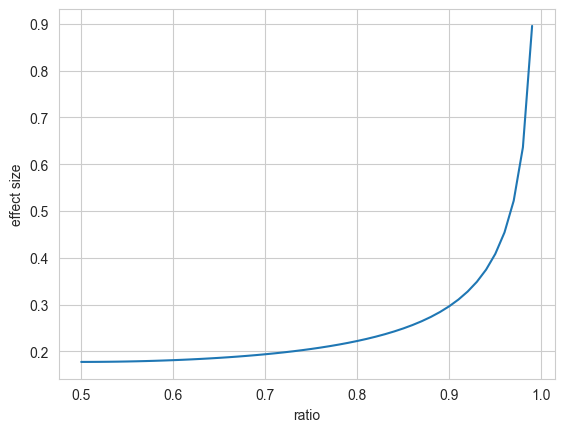

In [55]:
import matplotlib.pyplot as plt

ratios, effect_size = [], []
for ratio in range(50,100,1):
    ratios.append(ratio/100)
    ratio = ratio/100
    effect_size.append(tt_ind_solve_power(effect_size = None,
                           alpha = 0.05,
                           power = 0.8,
                           ratio = ratio/100,
                           nobs1 = 100000-ratio*100000,
                           alternative = "two-sided"))
plt.plot(ratios, effect_size)
plt.xlabel('ratio')
plt.ylabel('effect size')
plt.grid(True)
plt.show()

При ratio = 1

## Задание 4. Эффект Коэна (2/2)
Чему будет равна величина минимального эффекта - Cohen's D?

Введите ответ в поле ниже с точностью до ТРЕХ знаков в десятичной части.

Используйте точку для разделения целой и дробной части.

In [56]:
min(effect_size)

0.17763349343959106